In [102]:
import vitaldb
import pandas as pd
import requests
import json
import io
import time  # Importer time-modulet
import numpy as np

# Show all rows
pd.set_option('display.max_rows', None)  

# Show all columns
pd.set_option('display.max_columns', None)  

# Prevent truncation of column width
pd.set_option('display.max_colwidth', None)

# Prevent scientific notation (optional)
pd.set_option('display.float_format', '{:.3f}'.format)

In [70]:
#Tracklist inneholder informationene: case identifier, track name(navnet på målingen og apparat), 

# track identifier (den konkrete patients konktere måling)
track_list_url = "https://api.vitaldb.net/trks"
df_tracklist = pd.read_csv(track_list_url) #Skriv tracklist_url inne i parantesen

# Hent laboratoriedata fra API
laboratory_list_url = "https://api.vitaldb.net/labs"
df_laboratory = pd.read_csv(laboratory_list_url)

#Download clinical information
clinical_information_url = "https://api.vitaldb.net/cases"
df_clinical= pd.read_csv(clinical_information_url)



In [124]:
time=df_clinical[['caseid','casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend']]
min_time=time[['casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend']].div(60)

#caselength= time['caseend'].div(3600) -time['casestart'].div(3600)
#oplength= time['opend'].div(3600) -time['opstart'].div(3600)
#print('Caselenght', caselength[0:10])
#print('Operationlength', oplength[0:10])

preop=df_clinical[['dx','caseid']]

print(min_time[0:9])

print("There is this many nan values", preop.isna().sum())

print(preop[0:5])

#When both heart rate and percutaneous oxygen saturation signals are detected, patient monitoring is considered
#to have started and case recording begins immediately.

   casestart  caseend  anestart  aneend  opstart   opend
0      0.000  192.367    -9.200 180.800   27.800 172.800
1      0.000  262.350   -17.317 248.683   28.683 243.683
2      0.000   73.233    -9.833  70.167   18.167  50.167
3      0.000  349.833   -12.967 337.033   42.033 297.033
4      0.000  358.850   -16.817 373.183   43.183 338.183
5      0.000   85.750    -0.850  79.150   44.150  74.150
6      0.000  262.833     7.950 246.950   52.950 242.950
7      0.000   98.633   -12.467  95.533   12.533  82.533
8      0.000   74.683    -8.017  74.983   14.983  54.983
There is this many nan values dx        0
caseid    0
dtype: int64
                         dx  caseid
0             Rectal cancer       1
1  Advanced gastric cancer        2
2         Gallbladder stone       3
3   Advanced gastric cancer       4
4          Aortic aneurysm        5


In [5]:

pat_in_ICU = pd.read_csv("C:/Users/johns/Documents/10semester/P10/For_machinelearning/number_of_days_in_ICU.csv")

pat_in_ICU = pat_in_ICU[['caseid', 'icu_days_binary']]

ICU_patients = []
non_ICU_patients = []

#print(pat_in_ICU['caseid'].head())

#df_laboratory[df_laboratory['caseid'] == value]

def divide_into_ICU_and_non_ICU_patients():
    for index, row in pat_in_ICU.iterrows():
        if pat_in_ICU[pat_in_ICU['icu_days_binary'] == 1]:
            ICU_patients = pat_in_ICU['caseid']
        else: 
            non_ICU_patients = pat_in_ICU['caseid']

divide_into_ICU_and_non_ICU_patients()



ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [6]:
# DENNE FUNGERER NÅ!!!!!!!!!!!!!!!!  Til maria

#Denne funksjon henter tracks ned fra en URL, og printer dem. Deretter vil en tjekke hvor mange 0
# verdier som er i trakcet. Deretter vil den gemme tracket hvis trakcet har mindre enn et hvis antall 0 verdier#
# Opprett en liste for lagring av data som skal skrives til CSV

# Liste for spesielle variabler
special_variables = {
    "SNUADC/ART", "SNUADC/CVP", "SNUADC/ECG_II", "SNUADC/ECG_V5",
    "SNUADC/FEM", "SNUADC/PLETH", "Primus/AWP", "Primus/CO2",
    "BIS/EEG1_WAV", "BIS/EEG2_WAV", "CardioQ/ABP", "CardioQ/FLOW"
}

# Liste for å lagre data som skal skrives til CSV
saved_tracks = []

def collect_track_null_checker():
    # Hent hver trackidentifierverdi
    for index, row in df_tracklist.iterrows():
        if row['tname'] in special_variables:
            trackidentifier = row["tid"]
            trackdata_url = f"https://api.vitaldb.net/{trackidentifier}"
            response = requests.get(trackdata_url)

            # Konverter API-respons til en pandas DataFrame
            trackdata = pd.read_csv(io.StringIO(response.text))

            data_column = trackdata.columns[1]  # Velger den andre kolonnen (indeks 1)

            # Tell antall nullverdier
            zero_count = (trackdata[data_column] == 0).sum().sum()
            # Tell antall NaNverdier
            nan_count_per_column = trackdata[data_column].isna().sum().sum()

            total_non_value = zero_count+nan_count_per_column
            
            size = trackdata[data_column].size

            samplingperiode = trackdata.iloc[0,1]

            # Sjekk om mer enn 20% av verdiene er null
            
            if total_non_value >= 0.2 * size:
                print(f"NO.This track, {trackdata.columns[1]}, has {zero_count} 0s, {nan_count_per_column} NAN, combined {total_non_value} non informatory values out of {size} samples")
            else:
                print(f"Saved.This track, {trackdata.columns[1]}, has {zero_count} 0s, {nan_count_per_column} NAN, combined {total_non_value} non informatory values out of {size} samples")
                # Lagre caseid, tname og tid
                saved_tracks.append([row["caseid"], row["tname"], row["tid"], nan_count_per_column, zero_count, size, samplingperiode])

            # Vent 2 sekunder før neste forespørsel
            time.sleep(2)

    # Konverter listen til en DataFrame og lagre som CSV
    if saved_tracks:
        df_saved_tracks = pd.DataFrame(saved_tracks, columns=["caseid", "tname", "tid", "nan_count_per_column","zero_count", "size", "samplingperiode"])
        df_saved_tracks.to_csv("saved_tracks.csv", index=False)
        print("CSV file 'saved_tracks.csv' has been saved.")
    else:
        print("No tracks met the criteria for saving.")

# Kjør funksjonen
collect_track_null_checker()



Saved.This track, BIS/EEG1_WAV, has 418 0s, 164 NAN, combined 582 non informatory values out of 1477268 samples
Saved.This track, BIS/EEG2_WAV, has 235 0s, 164 NAN, combined 399 non informatory values out of 1477268 samples
Saved.This track, Primus/AWP, has 0 0s, 2593 NAN, combined 2593 non informatory values out of 721322 samples


KeyboardInterrupt: 

In [129]:
special_variables = {'Solar8000/PLETH_HR'}

def count_missing_vaules_in_numeric_tracks():
    for index, row in df_tracklist.iterrows():
        if row['tname'] in special_variables:
            trackid= row['tid']
            caseid = row['caseid']
            print('Caseid', caseid, 'TrackName:', row['tname'])
            trackdata_url = f"https://api.vitaldb.net/{trackid}"

            response = requests.get(trackdata_url)
            trackdata = pd.read_csv(io.StringIO(response.text))
        
            time_before_start = trackdata.iloc[0,0]

            min_gap = trackdata.iloc[:20]['Time'].diff().min()
            min_gap = round(min_gap, 0)
            print('Min Gap:', min_gap)

            sampled_times = trackdata['Time'].diff()

            res = sum(x > min_gap for x in sampled_times[1:])
            print(res)

    return res
    
count_missing_vaules_in_numeric_tracks()






Caseid 1 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
470
Caseid 2 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
304
Caseid 3 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
241
Caseid 4 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
205
Caseid 5 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
450
Caseid 6 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
349
Caseid 7 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
1010
Caseid 8 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
164
Caseid 9 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
142
Caseid 10 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
317
Caseid 11 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
149
Caseid 12 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
456
Caseid 13 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
869
Caseid 14 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
149
Caseid 15 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
86
Caseid 16 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
378
Caseid 17 TrackName: Solar8000/PLETH_HR
Min Gap: 2.0
418
Caseid 18 TrackName: Solar8000/PLETH_HR


KeyboardInterrupt: 

In [ ]:
pd.set_option('display.max_rows', None)
def count_tracks ():
    counts = df_tracklist['tname'].value_counts()
    display(counts)
        
count_tracks()

In [ ]:

def count_lab_results ():
    counts=df_laboratory.groupby('name')['caseid'].nunique()
    display(counts)
        
#count_lab_results()


def collect_laboratory_values_two_inputs(caseid, var_name):
    """
    Henter laboratorieværdier for en given patient (caseid) og en specifik laboratorievariabel (var_name).
    """
    if not isinstance(caseid, int) or not isinstance(var_name, str):
        return "Ugyldig input, vennligst bruk en integer for caseid og en string for variabelnavn"
    
    # Filtrer på både caseid og variabelnavn
    filtered_df = df_laboratory[(df_laboratory['caseid'] == caseid) & (df_laboratory['name'] == var_name)]
    
    # Hvis ingen resultater findes
    if filtered_df.empty:
        return f"Ingen data fundet for caseid {caseid} og variabel '{var_name}'"
    
    return filtered_df[['caseid', 'dt', 'result']]  # Returns caseid, time and results

# Eksempel på kald
caseid_test = 4  # Erstat med en reel caseid
variable_test = "cr"  # Erstat med en reel laboratorievariabel

print(collect_laboratory_values_two_inputs(caseid_test, variable_test))

#Denne funksjonen krevet et input, enten caseid eller variabelnavn. 
# Henter enten all information ift caseif eller all information ift variabelnavn

def collect_laboratory_values(value):
    if isinstance(value, int):  # Hvis input er patient caseid
        filtered_df = df_laboratory[df_laboratory['caseid'] == value]
        data_array = filtered_df[['dt', 'name', 'result']].values
        return [['dt', 'name', 'result']] + data_array.tolist()  # Include column names

    elif isinstance(value, str):  # Hvis input er en variabelnavn
        filtered_df = df_laboratory[df_laboratory['name'] == value]
        data_array = filtered_df[['dt', 'caseid', 'result']].values
        return [['dt', 'caseid', 'result']] + data_array.tolist()  # Include column names

    else:
        return "Ugyldig input, vennligst bruk enten en integer eller en string"

# Test function
#collect_laboratory_values(1)  # Example caseid
collect_laboratory_values("sao2")  #Example variable name




     caseid      dt  result
289       4  434356    0.66
290       4   84859    0.68
291       4  606476    0.76
292       4   21562    0.83
293       4  173382    0.87


[['dt', 'caseid', 'result'],
 [4628.0, 1.0, 96.0],
 [3060.0, 1.0, 100.0],
 [8921.0, 1.0, 100.0],
 [3078.0, 4.0, 97.0],
 [7460.0, 4.0, 98.0],
 [13624.0, 4.0, 99.0],
 [24374.0, 4.0, 99.0],
 [19934.0, 4.0, 100.0],
 [28903.0, 4.0, 100.0],
 [444425.0, 5.0, 97.0],
 [51065.0, 5.0, 99.0],
 [162205.0, 5.0, 99.0],
 [167131.0, 5.0, 99.0],
 [177839.0, 5.0, 99.0],
 [7172.0, 5.0, 100.0],
 [9947.0, 5.0, 100.0],
 [12310.0, 5.0, 100.0],
 [15000.0, 5.0, 100.0],
 [17498.0, 5.0, 100.0],
 [4092.0, 7.0, 99.0],
 [16294.0, 7.0, 99.0],
 [10855.0, 7.0, 100.0],
 [2827.0, 10.0, 97.0],
 [8502.0, 10.0, 99.0],
 [13597.0, 10.0, 100.0],
 [5412.0, 12.0, 83.0],
 [8555.0, 12.0, 94.0],
 [24395.0, 12.0, 98.0],
 [28212.0, 12.0, 98.0],
 [26697.0, 12.0, 98.0],
 [5099.0, 12.0, 98.0],
 [22845.0, 12.0, 99.0],
 [22413.0, 12.0, 99.0],
 [14879.0, 12.0, 99.0],
 [3413.0, 13.0, 99.0],
 [9230.0, 16.0, 95.0],
 [8276.0, 16.0, 96.0],
 [10447.0, 16.0, 99.0],
 [908.0, 16.0, 100.0],
 [1791.0, 17.0, 95.0],
 [12674.0, 17.0, 96.0],
 [8772.0, 17

      Time  SNUADC/ECG_II
0    0.000            NaN
1    0.002            NaN
2      NaN            NaN
3      NaN            NaN
4      NaN            NaN
5      NaN            NaN
6      NaN            NaN
7      NaN            NaN
8      NaN            NaN
9      NaN            NaN
10     NaN            NaN
11     NaN            NaN
12     NaN            NaN
13     NaN            NaN
14     NaN            NaN
15     NaN            NaN
16     NaN            NaN
17     NaN            NaN
18     NaN            NaN
19     NaN            NaN
20     NaN            NaN
21     NaN            NaN
22     NaN            NaN
23     NaN            NaN
24     NaN            NaN
25     NaN            NaN
26     NaN            NaN
27     NaN            NaN
28     NaN            NaN
29     NaN            NaN
30     NaN            NaN
31     NaN            NaN
32     NaN            NaN
33     NaN            NaN
34     NaN            NaN
35     NaN            NaN
36     NaN            NaN
37     NaN  

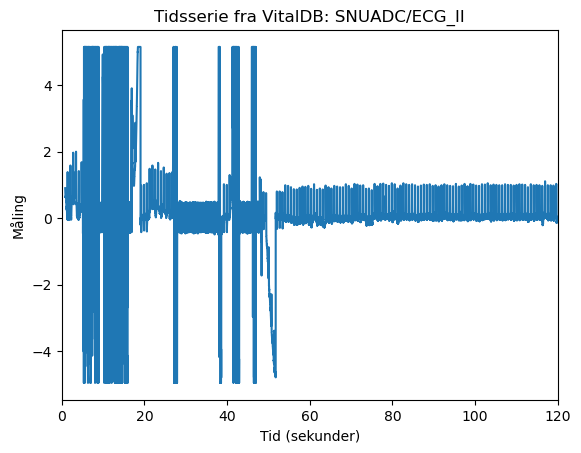

In [25]:
#HVIS MAN VIL PLOTTE ET Waveform data track. 
pd.set_option("display.max_rows", None)  # Vis alle rader
import numpy as np
import matplotlib.pyplot as plt

#LOADER SIGNALET  
trackdata_url = "http://api.vitaldb.net/8c9161aaae8cb578e2aa7b60f44234d98d2b3344"
response = requests.get(trackdata_url)
trackdata = pd.read_csv(io.StringIO(response.text))
print(trackdata.iloc[:1000]) 


#Henter ut signalfrekvensen, men bruker den ikke til noe her
signal_frequency = trackdata.iloc[1, 0]

#Starttid og endetidspunkt af signalet
start_time = trackdata.iloc[0,0]
end_time = trackdata.iloc[-1,0]
num_samples = len(trackdata)


# Generér tidsakse fra start til slut med korrekt sampling-rate
#time_axis = np.arange(start_time, end_time, signal_frequency)
time_axis = np.linspace(start_time, end_time, num_samples)

# Sikrer at tidsaksen har samme længde som trackdata
time_axis = time_axis[:len(trackdata)]

plt.plot(time_axis, trackdata.iloc[:, 1]) # Plotte Time vs. måling
plt.xlabel("Tid (sekunder)")
plt.xlim(0, 120)
plt.ylabel("Måling")
plt.title(f"Tidsserie fra VitalDB: {trackdata.columns[1]}")
plt.show()

       Time  Solar8000/NIBP_SBP
0    95.813                 150
1    97.812                 150
2    99.812                 150
3   101.829                 150
4   103.827                 150
5   105.826                 150
6   107.826                 150
7   109.826                 150
8   111.827                 150
9   113.825                 150
10  115.824                 150
11  117.823                 150
12  119.824                 150
13  121.822                 150
14  123.822                 150
15  125.821                 150
16  127.821                 150
17  129.819                 150
18  131.820                 150
19  133.821                 150
20  135.819                 150
21  137.819                 150
22  139.819                 150
23  141.818                 150
24  143.833                 150
25  145.817                 150
26  147.833                 150
27  149.832                 150
28  151.835                 150
29  153.830                 150
30  155.

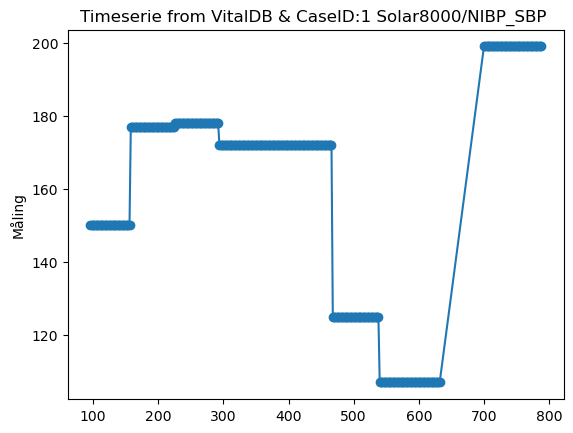

In [122]:
import numpy as np
import matplotlib.pyplot as plt

#If you want to plot a data track

             #Example: (1, 'Solar8000/ART_SBP')
def caseid_and_variable(caseid, var_name):
    if not isinstance(caseid, int) or not isinstance(var_name, str):
        return "Unvalid input"
    
    trackid_df = df_tracklist[(df_tracklist['caseid'] == caseid) & (df_tracklist['tname'] == var_name)]

    row = trackid_df.iloc[0]  # Get the first row (if multiple exist)
    if trackid_df.empty: 
        return f" No aviable data found for caseid {caseid} and variable '{var_name}'"
    
    return row['caseid'], row['tname'], row['tid']

caseid, tname, trackid = caseid_and_variable(1, 'Solar8000/NIBP_SBP')


#LOADER SIGNALET  
trackdata_url = f"http://api.vitaldb.net/{trackid}"
response = requests.get(trackdata_url)
trackdata = pd.read_csv(io.StringIO(response.text))
print(trackdata)

print('Samplenumbers:', len(trackdata['Time']))





plt.plot(trackdata["Time"], trackdata.iloc[:, 1], marker='o', linestyle='-') # Plotte Time vs. måling
#plt.xlabel("Tid (sekunder)")
plt.ylabel("Måling")
#plt.xlim(100,110)
plt.title(f"Timeserie from VitalDB & CaseID:{caseid} {tname} ")
plt.show()